# ライブラリ読み込み

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# utility
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import glob
import os
import sys
from sys import stderr

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# pytorch
# conda install pytorch torchvision -c pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# 囲碁ライブラリ
from sgfmill import sgf
from sgfmill import boards

# ルートに移動
%cd /Users/keimy/git/humanized-models-for-board-games/igo
%pwd


/Users/keimy/git/humanized-models-for-board-games/igo


'/Users/keimy/git/humanized-models-for-board-games/igo'

# Visualize Data

In [2]:
# .npy ファイルからデータをロード
moves = np.load('./preprocess/arrays_at_move.npy')

moves.shape

(33575793,)

In [ ]:
# movesを圧縮してnumpyに保存
np.savez_compressed('./preprocess/arrays_at_move.npz', moves)

In [ ]:
from src.board import visualize_matrix

items = moves[200]
black_matrix, white_matrix = items["black_matrix"], items["white_matrix"]
visualize_matrix(black_matrix, white_matrix)


# Make Dataloaders

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomGoDataset(Dataset):
    def __init__(self, numpy_arrays):
        self.data = numpy_arrays

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        black_matrix = item['black_matrix']
        white_matrix = item['white_matrix']
        black_rank = item['black_rank']
        white_rank = item['white_rank']
        move = item['move']
        X = np.stack([black_matrix, white_matrix], axis=0)
        return X, black_rank, white_rank, move


# 元のデータセットをカスタムデータセットに変換
moves2 = CustomGoDataset(moves)

# データセットの分割
train_size = int(0.8 * len(moves2))
valid_size = len(moves2) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(moves2, [train_size, valid_size])

# DataLoaderの定義
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# DataLoaderを使ったデータの取得
for X, black_rank, white_rank, move in train_loader:
    print(f"Combined Matrix Shape: {X.shape}")
    print(f"Black Rank: {black_rank.shape}")
    print(f"White Rank: {white_rank.shape}")
    print(f"Move: {move.shape}")
    break


Combined Matrix Shape: torch.Size([512, 2, 19, 19])
Black Rank: torch.Size([512])
White Rank: torch.Size([512])
Move: torch.Size([512])


# VAE-linear

In [ ]:
from src.model.VAE_linear import VAE_linear
z_dim = 10
assert z_dim >= 2
input_dim =  2 * 19 * 19
n_epochs = 3

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

model = VAE_linear(z_dim = z_dim, input_dim = input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x in train_loader:
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in valid_loader:
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


任意のxをもとに可視化

xはバッチで投げればy,zもバッチで返ってくる


xを単体で投げた場合はバッチサイズ=1と解釈されて

y,zもバッチサイズ=1の次元になるのでスクイーズが必要

In [ ]:
model.eval()

for x in valid_loader:
    print(x.shape, x.dtype)
    x = x.float().to(device)

    # xはバッチで投げている
    y, z = model(x)
    y = y.cpu().detach().numpy()

    print(y.shape, z.shape)
    break


xを単体で投げる

In [ ]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

# x単体を投げる
y, z = model(x)
y = y.cpu().detach().numpy()


x.shape, y.shape, z.shape

In [ ]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

y, z = model(x)
y = y.cpu().detach().numpy()

# yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0

print(z)

print("reconstructed move")
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

print("original move")
black_matrix, white_matrix = x.squeeze()
visualize_matrix(black_matrix, white_matrix)

Zのランダムサンプリング

In [ ]:
z = torch.randn([1, z_dim]).to(device)

model.eval()
y = model._decoder(z)
y = y.cpu().detach().numpy()

# yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0

print(z)
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

# VAE-CNN

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

rng = np.random.RandomState(1234)
random_state = 42
device = "mps" if torch.backends.mps.is_available() else "cpu"

# input_dim = 2*19*19


class CNNEncoder(nn.Module):
    """ CNNベースのエンコーダ """
    def __init__(self, z_dim, h_dim=128):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.fc1 = nn.Linear(2 * 19 * 19, h_dim)
        self.fc_mean = nn.Linear(h_dim, z_dim)
        self.fc_var = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # x.size(0)はバッチサイズ
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mean = self.fc_mean(x)
        # log_varは実数全部とるのでexp(log_var)すれば正数になる！
        log_var = self.fc_var(x)
        return mean, log_var


class CNNDecoder(nn.Module):
    """ CNNベースのデコーダ """
    def __init__(self, z_dim, h_dim=128, indim_deconv=2):
        super(CNNDecoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, indim_deconv * 19 * 19)

        self.deconv1 = nn.ConvTranspose2d(2, 2, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(2, 2, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(2, 2, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose2d(2, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, z, indim_deconv=2):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        # z.size(0)はバッチサイズ
        z = z.view(z.size(0), indim_deconv, 19, 19)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        reconstruction = torch.sigmoid(self.deconv4(z))
        return reconstruction


class VAE_CNN(nn.Module):
    """ CNNベースのVAE """
    def __init__(self, z_dim=64, h_dim=128):
        super(VAE_CNN, self).__init__()
        self.encoder = CNNEncoder(z_dim, h_dim)
        self.decoder = CNNDecoder(z_dim, h_dim)

    def reparameterize(self, mean, log_var):
        # log_varは実数全部とるがexpすることで正数のみ(STDは正数じゃないといけない)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var
    

    def loss(self, x):
        # モデルのforwardパスを使用して、再構成されたデータ、平均、対数分散を取得
        recon_x, mean, log_var = self.forward(x)

        # 再構成誤差（バイナリクロスエントロピー）
        # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        BCE = F.binary_cross_entropy(recon_x, x, reduction='mean', size_average=False)

        # KLダイバージェンス
        # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        KLD = -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

        return KLD, BCE  # KLダイバージェンスと再構成誤差を返す


学習

In [61]:
z_dim = 64
assert z_dim >= 2
n_epochs = 1
beta = 300

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

model = VAE_CNN(z_dim = z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for i, (x, black_rank, white_rank, move) in enumerate(tqdm(train_loader)):
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = beta * KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

        # ミニバッチごとに進捗を表示
        if i%1000 == 0: print(f"{i} batch: loss {loss.item():.3f} = {beta:.3f} * {KL_loss.item():.3f} + {reconstruction_loss.item():.3f}")


    losses_val = []
    model.eval()
    for x, black_rank, white_rank, move in tqdm(valid_loader):
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss
        losses_val.append(loss.cpu().detach().numpy())


    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


  0%|          | 2/52463 [00:00<5:53:14,  2.48it/s] 

0 batch: loss 261576.000 = 1000.000 * 0.002 + 261574.297


  2%|▏         | 1005/52463 [00:31<26:12, 32.71it/s]

1000 batch: loss 120315.344 = 1000.000 * 0.887 + 119427.984


  4%|▍         | 2005/52463 [01:01<25:16, 33.28it/s]

2000 batch: loss 118119.016 = 1000.000 * 0.878 + 117241.117


  6%|▌         | 3005/52463 [01:33<25:34, 32.23it/s]  

3000 batch: loss 113642.820 = 1000.000 * 0.921 + 112721.758


  8%|▊         | 4005/52463 [02:04<24:36, 32.82it/s]

4000 batch: loss 114217.914 = 1000.000 * 1.024 + 113193.945


 10%|▉         | 5005/52463 [02:34<24:22, 32.46it/s]

5000 batch: loss 121151.484 = 1000.000 * 1.088 + 120063.461


 11%|█▏        | 6005/52463 [03:05<24:00, 32.25it/s]

6000 batch: loss 107867.562 = 1000.000 * 1.088 + 106779.188


 13%|█▎        | 7005/52463 [03:35<23:07, 32.77it/s]

7000 batch: loss 109176.195 = 1000.000 * 1.136 + 108039.859


 15%|█▌        | 8005/52463 [04:06<22:42, 32.64it/s]

8000 batch: loss 111334.844 = 1000.000 * 1.183 + 110151.547


 17%|█▋        | 9005/52463 [04:36<22:19, 32.43it/s]

9000 batch: loss 109314.359 = 1000.000 * 1.310 + 108004.148


 19%|█▉        | 10005/52463 [05:07<21:35, 32.78it/s]

10000 batch: loss 107999.094 = 1000.000 * 1.316 + 106683.000


 21%|██        | 11005/52463 [05:38<21:05, 32.77it/s]

11000 batch: loss 110779.266 = 1000.000 * 1.353 + 109426.344


 23%|██▎       | 12005/52463 [06:09<21:14, 31.76it/s]

12000 batch: loss 106951.922 = 1000.000 * 1.375 + 105577.250


 25%|██▍       | 13005/52463 [06:39<20:04, 32.75it/s]

13000 batch: loss 108002.734 = 1000.000 * 1.371 + 106631.562


 27%|██▋       | 14005/52463 [07:10<20:26, 31.36it/s]

14000 batch: loss 103572.125 = 1000.000 * 1.399 + 102173.359


 29%|██▊       | 15005/52463 [07:41<19:10, 32.56it/s]

15000 batch: loss 104509.055 = 1000.000 * 1.410 + 103099.359


 31%|███       | 16005/52463 [08:11<18:35, 32.68it/s]

16000 batch: loss 98332.203 = 1000.000 * 1.422 + 96910.602


 32%|███▏      | 17005/52463 [08:42<17:48, 33.17it/s]

17000 batch: loss 110427.594 = 1000.000 * 1.467 + 108960.719


 34%|███▍      | 18005/52463 [09:12<17:15, 33.27it/s]

18000 batch: loss 103784.844 = 1000.000 * 1.478 + 102306.750


 36%|███▌      | 19005/52463 [09:42<17:19, 32.19it/s]

19000 batch: loss 112078.844 = 1000.000 * 1.504 + 110575.016


 38%|███▊      | 20005/52463 [10:13<16:09, 33.47it/s]

20000 batch: loss 105378.688 = 1000.000 * 1.494 + 103885.047


 40%|████      | 21005/52463 [10:43<15:53, 32.99it/s]

21000 batch: loss 107421.406 = 1000.000 * 1.518 + 105903.781


 42%|████▏     | 22005/52463 [11:13<15:20, 33.09it/s]

22000 batch: loss 106625.164 = 1000.000 * 1.514 + 105111.281


 44%|████▍     | 23005/52463 [11:44<15:09, 32.38it/s]

23000 batch: loss 109435.781 = 1000.000 * 1.527 + 107908.953


 46%|████▌     | 24005/52463 [12:14<14:24, 32.93it/s]

24000 batch: loss 107148.555 = 1000.000 * 1.545 + 105603.977


 48%|████▊     | 25005/52463 [12:44<14:03, 32.55it/s]

25000 batch: loss 105410.469 = 1000.000 * 1.535 + 103875.953


 50%|████▉     | 26005/52463 [13:15<13:15, 33.26it/s]

26000 batch: loss 105179.367 = 1000.000 * 1.555 + 103624.469


 51%|█████▏    | 27005/52463 [13:45<12:53, 32.93it/s]

27000 batch: loss 105007.695 = 1000.000 * 1.554 + 103454.188


 53%|█████▎    | 28005/52463 [14:15<12:29, 32.62it/s]

28000 batch: loss 108603.367 = 1000.000 * 1.558 + 107045.633


 55%|█████▌    | 29005/52463 [14:45<11:56, 32.76it/s]

29000 batch: loss 109586.547 = 1000.000 * 1.557 + 108030.008


 57%|█████▋    | 30005/52463 [15:16<11:24, 32.81it/s]

30000 batch: loss 105105.883 = 1000.000 * 1.571 + 103535.125


 59%|█████▉    | 31005/52463 [15:46<10:42, 33.42it/s]

31000 batch: loss 101452.625 = 1000.000 * 1.577 + 99875.594


 61%|██████    | 32005/52463 [16:16<10:17, 33.14it/s]

32000 batch: loss 105430.125 = 1000.000 * 1.585 + 103844.648


 63%|██████▎   | 33005/52463 [16:47<09:59, 32.48it/s]

33000 batch: loss 104800.516 = 1000.000 * 1.591 + 103209.344


 65%|██████▍   | 34005/52463 [17:17<09:09, 33.57it/s]

34000 batch: loss 105284.352 = 1000.000 * 1.586 + 103697.984


 67%|██████▋   | 35005/52463 [17:47<08:54, 32.64it/s]

35000 batch: loss 103198.648 = 1000.000 * 1.605 + 101593.359


 69%|██████▊   | 36005/52463 [18:17<08:17, 33.06it/s]

36000 batch: loss 103395.203 = 1000.000 * 1.589 + 101805.820


 71%|███████   | 37005/52463 [18:48<07:54, 32.60it/s]

37000 batch: loss 102680.484 = 1000.000 * 1.590 + 101090.016


 72%|███████▏  | 38005/52463 [19:18<07:25, 32.47it/s]

38000 batch: loss 105670.836 = 1000.000 * 1.608 + 104062.664


 74%|███████▍  | 39005/52463 [19:49<06:51, 32.67it/s]

39000 batch: loss 103577.094 = 1000.000 * 1.620 + 101957.219


 76%|███████▋  | 40005/52463 [20:19<06:10, 33.63it/s]

40000 batch: loss 104243.328 = 1000.000 * 1.623 + 102620.828


 78%|███████▊  | 41005/52463 [20:50<05:46, 33.03it/s]

41000 batch: loss 102534.031 = 1000.000 * 1.631 + 100902.805


 80%|████████  | 42005/52463 [21:20<05:20, 32.59it/s]

42000 batch: loss 101793.742 = 1000.000 * 1.637 + 100156.828


 82%|████████▏ | 43005/52463 [21:50<04:47, 32.92it/s]

43000 batch: loss 102185.430 = 1000.000 * 1.631 + 100554.508


 84%|████████▍ | 44005/52463 [22:21<04:09, 33.83it/s]

44000 batch: loss 104948.938 = 1000.000 * 1.639 + 103310.320


 86%|████████▌ | 45005/52463 [22:51<03:49, 32.45it/s]

45000 batch: loss 100387.836 = 1000.000 * 1.650 + 98737.953


 88%|████████▊ | 46005/52463 [23:21<03:10, 33.90it/s]

46000 batch: loss 99218.453 = 1000.000 * 1.616 + 97602.203


 90%|████████▉ | 47005/52463 [23:52<02:46, 32.81it/s]

47000 batch: loss 101803.344 = 1000.000 * 1.641 + 100161.906


 92%|█████████▏| 48005/52463 [24:22<02:11, 33.81it/s]

48000 batch: loss 105691.273 = 1000.000 * 1.640 + 104050.781


 93%|█████████▎| 49005/52463 [24:52<01:43, 33.46it/s]

49000 batch: loss 105398.977 = 1000.000 * 1.648 + 103750.547


 95%|█████████▌| 50005/52463 [25:23<01:15, 32.68it/s]

50000 batch: loss 100103.938 = 1000.000 * 1.621 + 98482.531


 97%|█████████▋| 51005/52463 [25:53<00:44, 32.41it/s]

51000 batch: loss 103207.070 = 1000.000 * 1.633 + 101574.367


 99%|█████████▉| 52005/52463 [26:23<00:13, 33.17it/s]

52000 batch: loss 94785.523 = 1000.000 * 1.663 + 93122.852


100%|██████████| 13116/13116 [03:02<00:00, 71.82it/s]


EPOCH: 1    Train Lower Bound: 106754.007812 (KL_loss: 1.458632. reconstruction_loss: 105295.367188)    Valid Lower Bound: 102344.304688


学習すみモデルを保存

In [62]:
import torch
import datetime

# 現在の時刻を取得
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M')

# 保存するファイルのパスを設定
save_path = f"params/model_{current_time}.pth"

# モデルのパラメーターを保存
torch.save(model.state_dict(), save_path)

モデルを読み込み

In [24]:
# モデルを読み込む
z_dim = 64
device = "mps" if torch.backends.mps.is_available() else "cpu"
save_path = "params/model_202401112108.pth"

model = VAE_CNN(z_dim = z_dim).to(device)
model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

再構成moveを可視化

reconstructed move


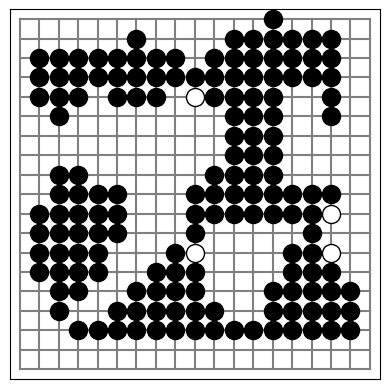

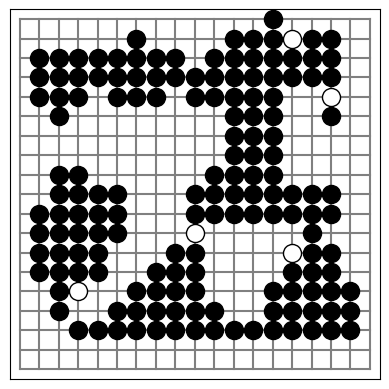

0

In [71]:
from src.board import visualize_matrix

model.eval()

i = 30
x, black_rank, white_rank, move = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.unsqueeze(0)
x = x.to(device)

y, z_mu, z_logvar = model(x)
y = y.cpu().detach().numpy()

# # yの閾値処理
th = 0.22
y[y >= th] = 1
y[y < th] = 0


print("reconstructed move")
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)
# visualize_matrix(white_matrix, black_matrix)

print("original move")
black_matrix, white_matrix = x.squeeze()
visualize_matrix(black_matrix, white_matrix)

潜在空間の可視化

  0%|          | 1000/6715159 [00:03<7:12:58, 258.45it/s]


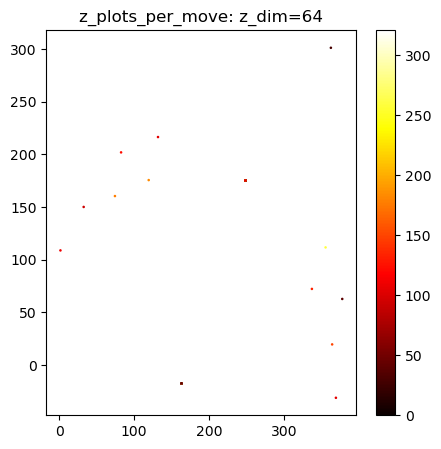

In [51]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

def reparameterize(mean, log_var):
    # log_varは実数全部とるがexpすることで正数のみ(STDは正数じゃないといけない)
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mean + eps * std

model.eval()

z_list = []
labels = []
label_name = "move"
for i, (x, black_rank, white_rank, move) in enumerate(tqdm(valid_dataset)):
    if i == 1000: break

    label = move if label_name=="move" else black_rank if label_name=="black_rank" else white_rank
    labels.append(label)
    x = torch.from_numpy(x).float()
    x = x.unsqueeze(0)
    x = x.to(device)
    y, z_mu, z_logvar = model(x)
    # z = reparameterize(z_mu, z_logvar)
    z = z_mu
    z_list.append(z.cpu().detach().numpy()[0])

z_val = np.stack(z_list)

# 'TSNE' または 'PCA'
REDUC = 'TSNE' 
if z_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_val).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_val).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif z_dim == 2:
    z_reduc = z_val.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")


# colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna',
#           'darkturquoise', 'slateblue', 'orange', 'darkcyan', 'tomato']

cmap = plt.cm.hot
vmin, vmax = min(labels), max(labels)
colors = [cmap((label - vmin) / (vmax - vmin)) for label in labels]


plt.figure(figsize=(5,5))

plt.scatter(*z_reduc, s=0.7, c=colors)
# plt.scatter(*z_reduc, s=0.7, c=[colors[label] for label in labels])

# 凡例
# for i in range(len(colors)): plt.scatter([],[], c=colors[i], label=i)
# plt.legend()

# 凡例の代わりにカラーバー
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, ax=plt.gca())  # 現在の軸にカラーバーを追加

plt.title(f"z_plots_per_{label_name}: z_dim={z_dim}")
plt.savefig(f"figures/z_plots_per_{label_name}.png")

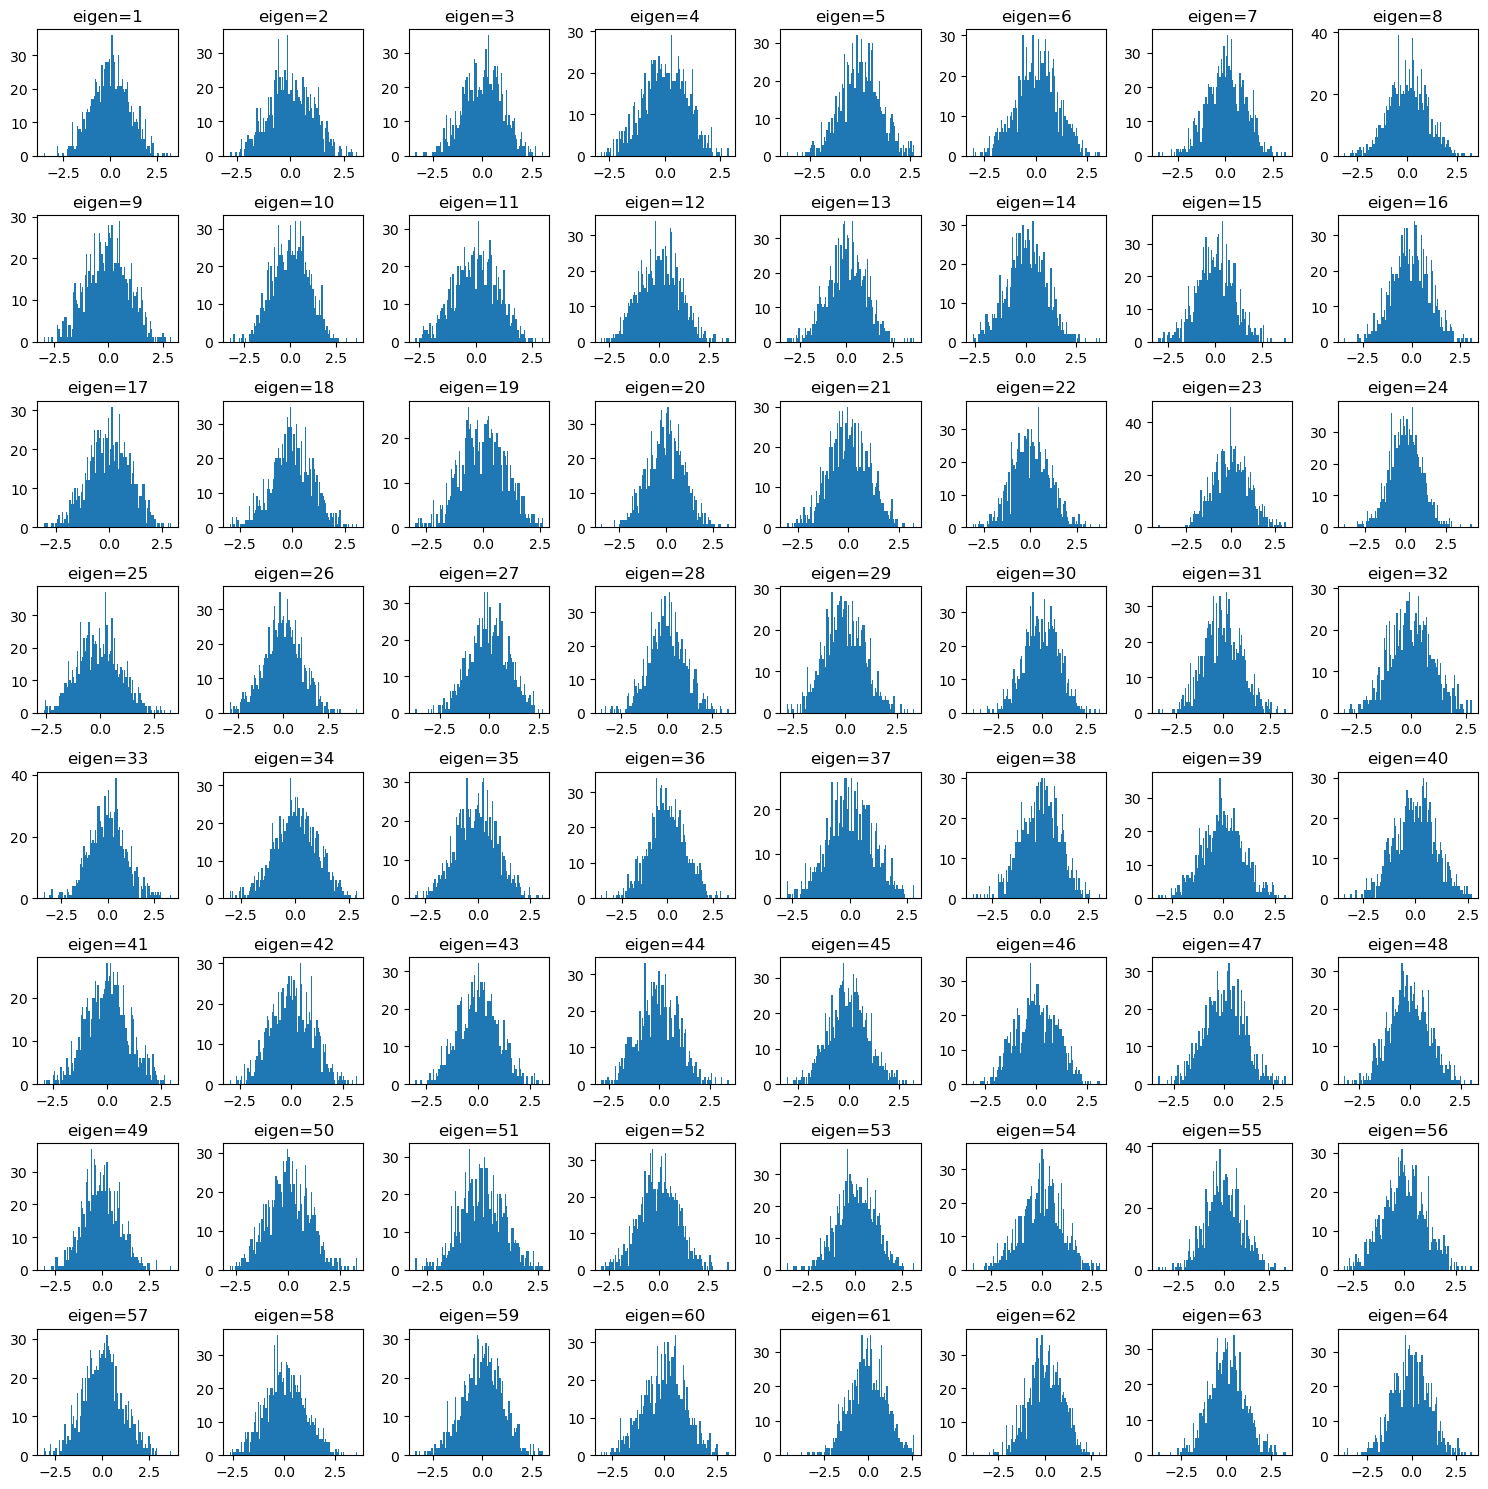

In [50]:
# z_dim の定義
z_dim = 64

# 8x8のサブプロットを作成
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# 各eigenベクトルに対してヒストグラムを描画
for i in range(z_dim):
    row, col = divmod(i, 8)  # サブプロットの行と列を計算
    ax = axes[row, col]
    z_per_eigen = z_val[:, i]
    vmin, vmax = min(z_per_eigen), max(z_per_eigen)
    ax.hist(z_per_eigen, bins=100, range=(vmin, vmax))
    ax.set_title(f"eigen={i+1}")

plt.tight_layout()
plt.show()


In [ ]:
len(valid_dataset)

Zをランダムサンプリング

In [ ]:
from src.board import visualize_matrix

# ランダムな潜在変数 z をサンプリング
# ここでの z_dim は、モデルで使用されている潜在空間の次元数
z = torch.randn(1, z_dim).to(device)

# 学習済みのモデルの decoder 部分を使用して z を再構成
with torch.no_grad():  # 勾配計算を行わない
    model.eval()
    y = model.decoder(z)

y = y.cpu().detach().numpy()


# yの閾値処理
th = 0.25
y[y >= th] = 1
y[y < th] = 0

print("z_dim:", z_dim)
# print(z)

black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)
